In [1]:
# The Base libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import laspy

In [2]:
# The Deep Learning libraries
import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator

In [3]:
import torch
print('CUDA available -> ', torch.cuda.is_available())
print('CUDA GPU number -> ', torch.cuda.device_count())
print('GPU -> ', torch.cuda.get_device_name())

CUDA available ->  True
CUDA GPU number ->  1
GPU ->  NVIDIA GeForce RTX 3060


In [4]:
CHECKPOINT_PATH = "../sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

## 2D image segmentation

In [6]:
image_bgr = cv2.imread("../DATA/biscarosse.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [7]:
mask_generator = SamAutomaticMaskGenerator(sam)
result = mask_generator.generate(image_rgb)

In [8]:
def sam_masks(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    c_mask=[]
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.8)))
        c_mask.append(img)
    return c_mask

In [9]:
print('Mem allocated by other programs: ', torch.cuda.memory_allocated(), 'reserved:', torch.cuda.memory_reserved())
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
gc.collect()
torch.cuda.empty_cache()


# mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

Mem allocated by other programs:  2640005632 reserved: 9154068480


In [ ]:
fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72,
np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(image_rgb)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig("../test_result.jpg")

## Orthographic Projection

In [10]:
def cloud_to_image(pcd_np, resolution):
    minx = np.min(pcd_np[:, 0])
    maxx = np.max(pcd_np[:, 0])
    miny = np.min(pcd_np[:, 1])
    maxy = np.max(pcd_np[:, 1])
    width = int((maxx - minx) / resolution) + 1
    height = int((maxy - miny) / resolution) + 1
    image = np.zeros((height, width, 3), dtype=np.uint8)
    for point in pcd_np:
        x, y, *_ = point
        r, g, b = point[-3:]
        pixel_x = int((x - minx) / resolution)
        pixel_y = int((maxy - y) / resolution)
        image[pixel_y, pixel_x] = [r, g, b]
    return image

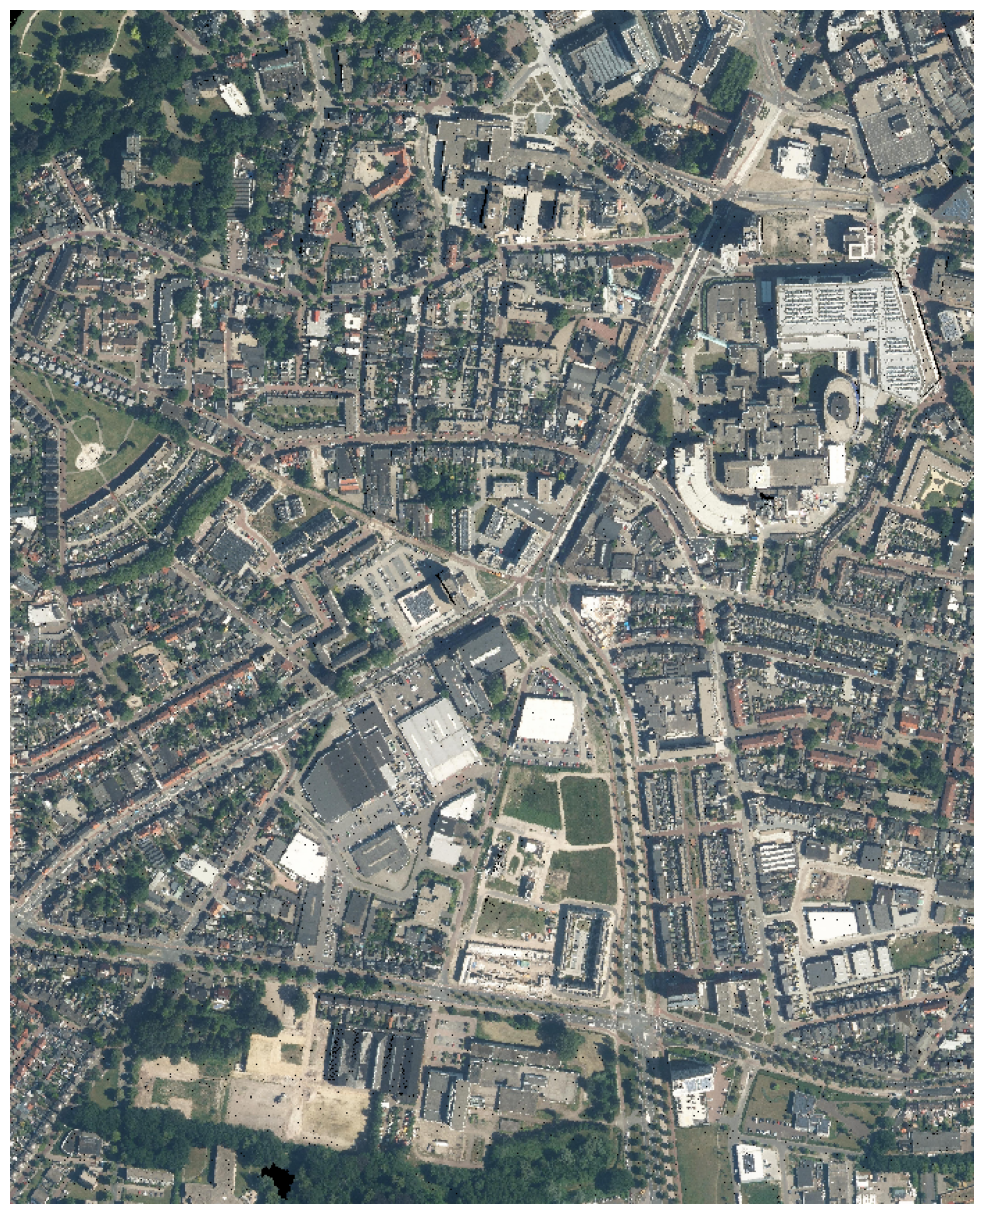

In [11]:
#Reading the point cloud with laspy
pcd = laspy.read("../DATA/34FN2_18.las")
#Transforming the point cloud to Numpy
pcd_np = np.vstack((pcd.x, pcd.y, pcd.z, (pcd.red/65535*255).astype(int),
(pcd.green/65535*255).astype(int),
(pcd.blue/65535*255).astype(int))).transpose()

#Ortho-Projection
orthoimage = cloud_to_image(pcd_np, 1.5)
#Plotting and exporting
fig = plt.figure(figsize=(np.shape(orthoimage)[1]/72,
np.shape(orthoimage)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(orthoimage)
plt.axis('off')
plt.savefig("../DATA/34FN2_18_orthoimage.jpg")

In [12]:
def generate_spherical_image(center_coordinates, point_cloud, colors,resolution_y=500):
    # Translate the point cloud by the negation of the center coordinates
    translated_points = point_cloud - center_coordinates
    # Convert 3D point cloud to spherical coordinates
    theta = np.arctan2(translated_points[:, 1], translated_points[:, 0])
    phi = np.arccos(translated_points[:, 2] / np.linalg.norm(translated_points, axis=1))
    # Map spherical coordinates to pixel coordinates
    x = (theta + np.pi) / (2 * np.pi) * (2 * resolution_y)
    y = phi / np.pi * resolution_y
    # Create the spherical image with RGB channels
    resolution_x = 2 * resolution_y
    image = np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8)
    # Create the mapping between point cloud and image coordinates
    mapping = np.full((resolution_y, resolution_x), -1, dtype=int)
    # Assign points to the image pixels
    for i in range(len(translated_points)):
        ix = np.clip(int(x[i]), 0, resolution_x - 1)
        iy = np.clip(int(y[i]), 0, resolution_y - 1)
        if mapping[iy, ix] == -1 or np.linalg.norm(translated_points[i]) < np.linalg.norm(translated_points[mapping[iy, ix]]):
            mapping[iy, ix] = i
            image[iy, ix] = colors[i]
    return image, mapping

In [13]:
#Loading the las file from the disk
las = laspy.read("../DATA/ITC_BUILDING.las")
#Transforming to a numpy array
coords = np.vstack((las.x, las.y, las.z))
point_cloud = coords.transpose()
#Gathering the colors
r=(las.red/65535*255).astype(int)
g=(las.green/65535*255).astype(int)
b=(las.blue/65535*255).astype(int)
colors = np.vstack((r,g,b)).transpose()

resolution = 500
#Defining the position in the point cloud to generate a panorama
center_coordinates = [189, 60, 2]

In [14]:
#Function Execution
spherical_image, mapping= generate_spherical_image(center_coordinates,point_cloud, colors, resolution)

In [15]:
count = np.count_nonzero(mapping != -1)
print(count)
print(spherical_image.shape)

243418
(500, 1000, 3)


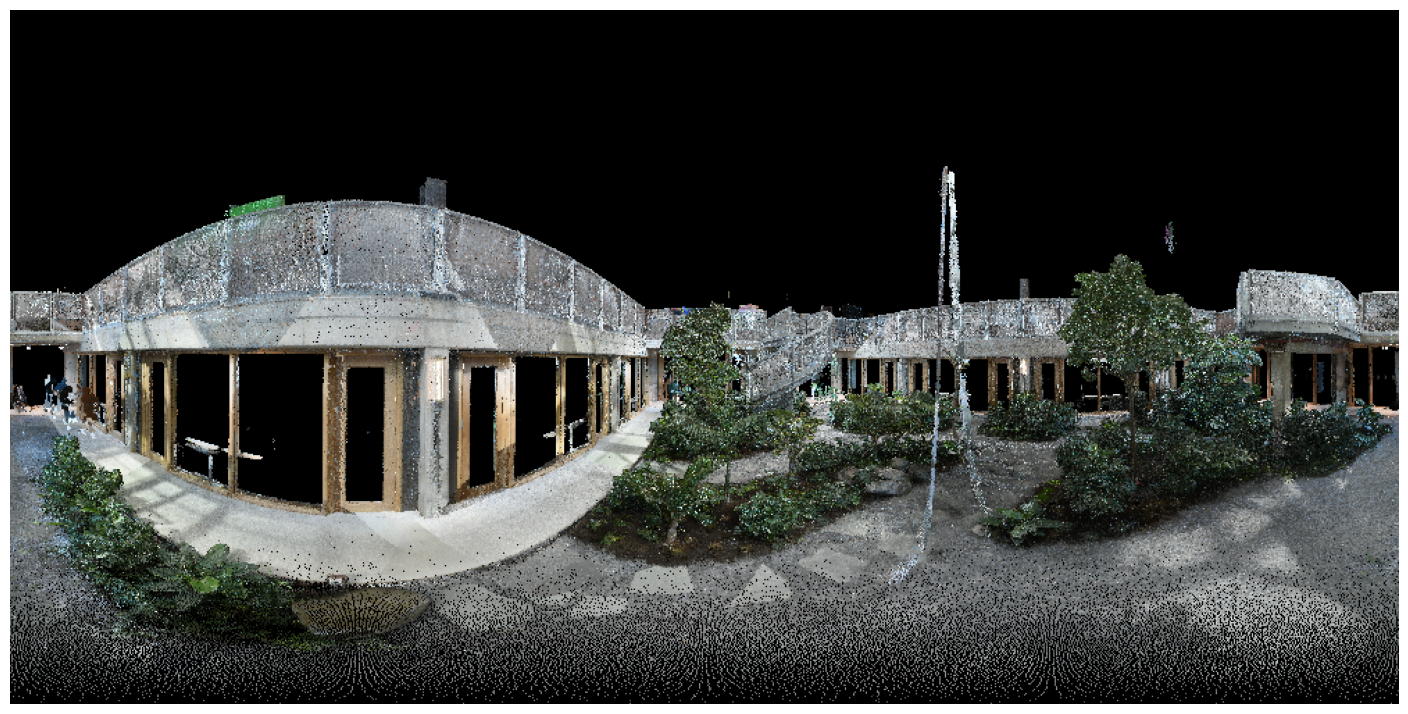

In [16]:
#Plotting with matplotlib
fig = plt.figure(figsize=(np.shape(spherical_image)[1]/72,
np.shape(spherical_image)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(spherical_image)
plt.axis('off')
#Saving to the disk
plt.savefig("../DATA/ITC_BUILDING_spherical_projection.jpg")

## SAM SEGMENTATION

In [17]:
import time

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)
image_bgr = cv2.imread("../DATA/ITC_BUILDING_spherical_projection.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
t0 = time.time()
result = mask_generator.generate(image_rgb)
t1 = time.time()

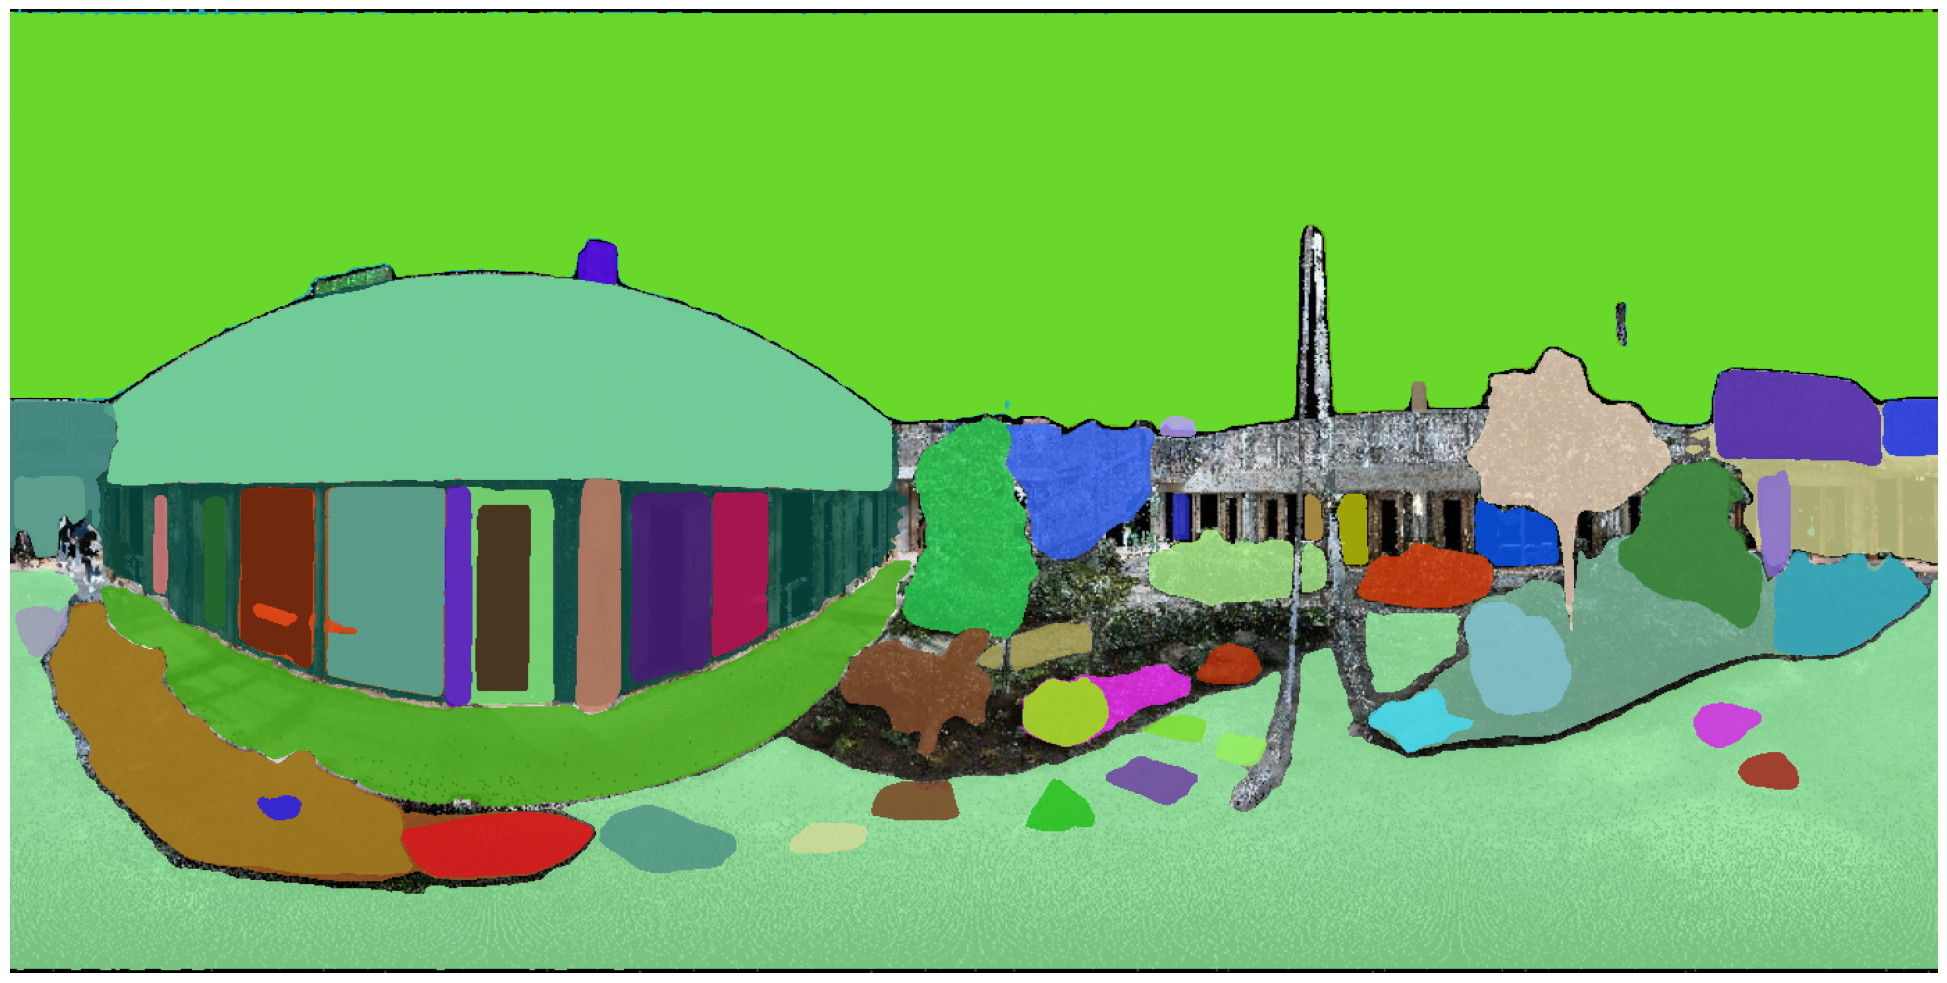

In [18]:
fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72,
np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(image_rgb)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig("../DATA/ITC_BUILDING_spherical_projection_segmented.jpg")

In [39]:
def color_point_cloud(image_path, point_cloud,mapping):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    modified_point_cloud = np.zeros((point_cloud.shape[0],point_cloud.shape[1]+3), dtype=np.float32)
    modified_point_cloud[:, :3] = point_cloud
    for iy in range(h):
        for ix in range(w):
            point_index = mapping[iy, ix]
            if point_index != -1:
                color = image[iy, ix]
                modified_point_cloud[point_index, 3:] = color

    return modified_point_cloud

In [40]:
image_path = "../ITC_BUILDING_spherical_projection.jpg"
image = cv2.imread(image_path)
print(image.shape)
print(mapping.shape)
modified_point_cloud = color_point_cloud(image_path, point_cloud,mapping)

(500, 1000, 3)
(500, 1000)


In [41]:
def export_point_cloud(cloud_path, modified_point_cloud):
    # 1. Create a new header
    header = laspy.LasHeader(point_format=3, version="1.2")
    header.add_extra_dim(laspy.ExtraBytesParams(name="random",type=np.int32))
    # 2. Create a Las
    las_o = laspy.LasData(header)
    las_o.x = modified_point_cloud[:,0]
    las_o.y = modified_point_cloud[:,1]
    las_o.z = modified_point_cloud[:,2]
    las_o.red = modified_point_cloud[:,3]
    las_o.green = modified_point_cloud[:,4]
    las_o.blue = modified_point_cloud[:,5]
    las_o.write(cloud_path)
    print("Export succesful at: ", cloud_path)
    return

In [42]:
export_point_cloud("../DATA/pcd_results.las", modified_point_cloud)

Export succesful at:  ../DATA/pcd_results.las
